# PyOD: Anomaly Detection

## 1. Overview

### 1.1. Types of anomalies
- *Local anomalies*: Refers to the anomalies that deviant from their local neighbors. Imagine that there are 3 clusters in the dataset, in each cluster have some points that are different from other points in the same cluster. They are local anomalies.
- *Global anomlies*: The anomalies that far from normal data. Consider again 3 clusters in the dataset, if there are some points which far from all 3 clusters,that are called global anomalies.
- *Dependency anomalies*: refer to the data points that do not follow the dependency structure which normal data follow. Example salary covariates with education but anomalies do not.
- *Clustered anomalies*: is group of abnomalies, the data points are not scattered in space but appear in a group that are different from normal data

:::{image} ../image/types_of_anomaly.png
:height: 220px
:align: center
:::

### 1.2. Approaches
Beside statistical aproaches such as IQR, Z-score, anomalies can be detected throught 3 types of ML algorithms:
- Unsupervised: The most popular approaches in reality is unsupervied methods, detection algorithms can be essentially grouped in three classes: 
    - Proximity/nearest neighbor-based methods: This method assume that a data point is an outlier if the nearest neighbors of the point are far away in space, that is, the proximity of the point to its neighbors significantly deviates from the proximity of most of the other points to their neighbors in the data set. Some popular algorithms are LOF, COF, kNN, SOD, HBOS
    - Probabilistic/linear-based: This method constructs the empirical distribution of the data set then predict the tail probabilities of each given data point to determine its level of *extremeness*. OCSVM, COPOD, PCA are usually used in AD
    - Ensemble/isolation-based methods: The idea is to train several anomaly detectors with varying hyperparameters in parallel and then combine its result in the anomaly detection phase, this method suitable for high-dimensional and large-scale dataset. Some popular algorithms are IsolationForest, LODA
- Supervised: The anomalies detection are treated as binary classification (which are very rare)
- Semi-supervised: Semi-supervised AD algorithms can capitalize the supervision from partial labels, while keeping the ability to detect unseen types of anomalies.

## 2. Statistical approaches
An outlier is a data point that differs significantly from other observations. Outliers can cause serious problems in statistical analysis. Detecting outliers is more likely be an art rather than a science, therefore you need both quantitative and qualitative methods to identify outliers.

However, there's no best rule for handling outliers. You need to ask yourself *Why are they outliers?* and *How can they affect your analysis?*. In this section, we discuss how to detect and handle outliers using Feature-engine.

In [ ]:
import numpy as np
import pandas as pd

### 2.1. Stategies

#### Z-score
Given a vector, $\mathbf{x}$, we calculate z-score (denoted $\mathbf{z}$) with the following formula:

$$z = \frac{x-\mu}{\sigma}$$

The approach of this method is to eliminate values of $z<-3$ and $z>3$. You can also remove $x<\mu-3\sigma$ and $x>\mu+3\sigma$ which gives the same result. Notice that the coefficient can be changed to 2.5 or 3.5 depends on the problem.

In [8]:
def outliers_zscore(array, z):
    'Return a new array has the outliers being replaced with NaN.'
    import numpy as np
    array = np.array(array, dtype=float)
    mean = array.mean()
    std = array.std()
    lower = mean - z*std
    upper = mean + z*std
    array[(array < lower) | (array > upper)] = np.nan
    return array

#### Interquartile range
This method considers eliminating values that is lower than $Q_1-1.5\times \text{IQR}$ or higher than $Q_3+1.5\times \text{IQR}$, where: $Q_1$, $Q_2$ and $Q_3$ are the quartiles; $\text{IQR}=Q_3-Q_1$ is the interquartile range.

In [12]:
def outliers_iqr(array):
    import numpy as np
    array = np.array(array, dtype=float)
    Q1, Q3 = np.quantile(array, [0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    array[(array < lower) | (array > upper)] = np.nan
    return array

### 2.2. Handling

In [1]:
import numpy as np
import pandas as pd

from feature_engine import outliers

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

#### Clipping
The class [`Winsorizer`](https://feature-engine.readthedocs.io/en/latest/api_doc/outliers/Winsorizer.html) detects outliers based on z-score, IQR and percentiles rule and replace these outliers by the maximum/minimum values at automatically determined values

In [41]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.shape

(4898, 12)

In [47]:
winsorizer = outliers.Winsorizer(capping_method='iqr', tail='both', variables=['citric_acid'])
wine_rmo = winsorizer.fit_transform(wine)
wine_rmo.shape

(4898, 12)

<AxesSubplot:ylabel='citric_acid'>

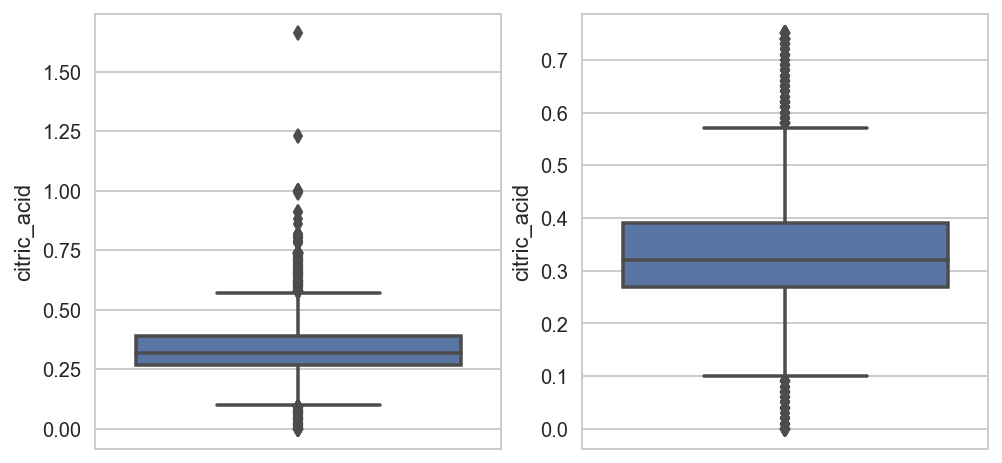

In [53]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.boxplot(y=wine.citric_acid, ax=ax[0])                      
sns.boxplot(y=wine_rmo.citric_acid, ax=ax[1])

#### Trimming
[`OutlierTrimmer`](https://feature-engine.readthedocs.io/en/latest/api_doc/outliers/OutlierTrimmer.html) detects outliers based on z-score, IQR and percentiles rule and removes observations with outliers from the dataset.

In [41]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.shape

(4898, 12)

In [44]:
trimmer = outliers.OutlierTrimmer(capping_method='iqr', tail='both', variables=['citric_acid'])
wine_rmo = trimmer.fit_transform(wine)

In [46]:
wine_rmo.shape

(4876, 12)

#### Transforming
Another strategy to handling outliers is to perform a log transformation on the data, which dampens the effect of outliers.

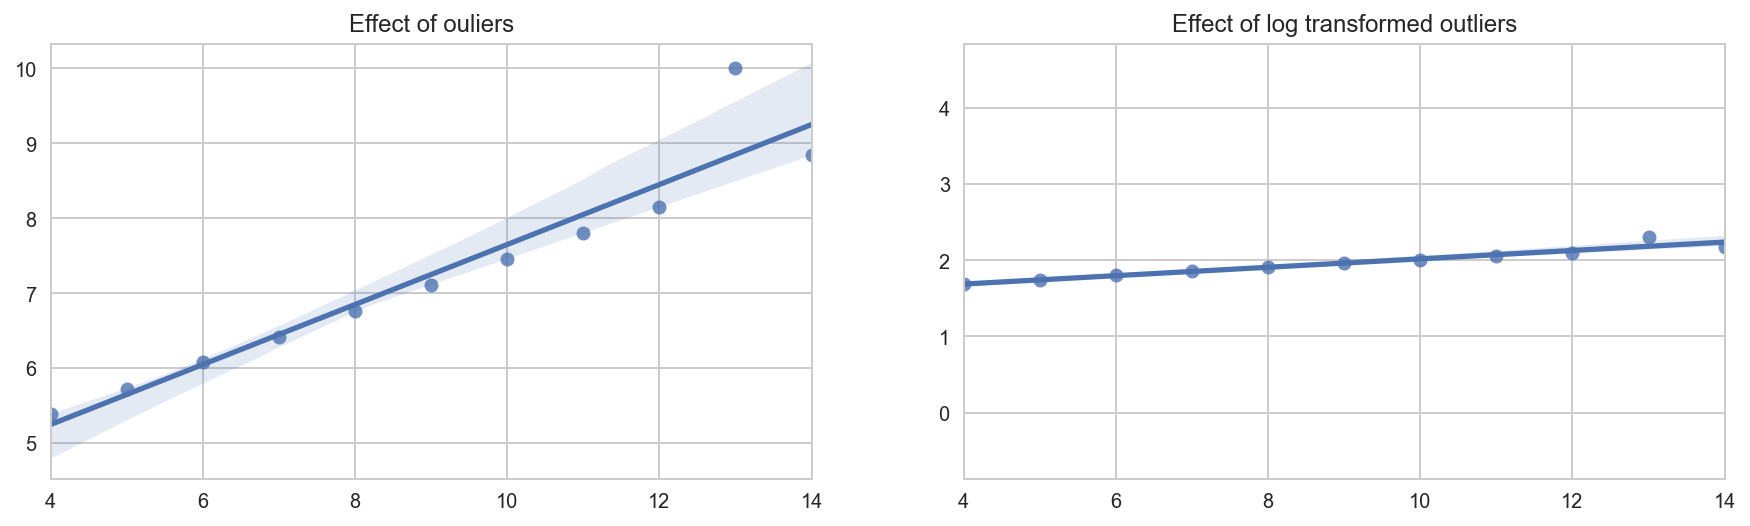

In [3]:
x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y = [7.46, 6.77, 10, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]

fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(15,4))
sns.regplot(x=x, y=y, ax=ax[0]).set_title('Effect of ouliers')
sns.regplot(x=x, y=np.log(y), ax=ax[1]).set_title('Effect of log transformed outliers')
plt.axis('equal')
plt.show()

## 3. Inspired variants

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns

from pyod.models import pca, cblof, ocsvm, knn
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

### 3.1. Dimensional reduction

As far as we know, PCA is a technique which break down a matrix into vectors called principal components, then reconstruct the original data using just the first few principal components in a lower dimensional space. The reconstructed data points that are the most different from the corresponding original points are anomalous points - which is more obvious on the hyperplane constructed by the eigenvectors with small eigenvalues. Therefore, outlier scores can be obtained as the sum of the projected distance of a sample on all eigenvectors. The
[`PCA`](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.pca)
model in Pyod can calculate the outlier scores and predict which observation is outlier 

In [3]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [13]:
pca = pca.PCA(n_selected_components=3)
pca.fit(wine)

PCA(contamination=0.1, copy=True, iterated_power='auto', n_components=None,
  n_selected_components=3, random_state=None, standardization=True,
  svd_solver='auto', tol=0.0, weighted=True, whiten=False)

In [39]:
ab_score = pca.decision_function(wine)
outlier = pca.predict(wine) #return 0/1 indicate index of outliers

min_ab_score = np.min(ab_score[np.where(outlier==1)])

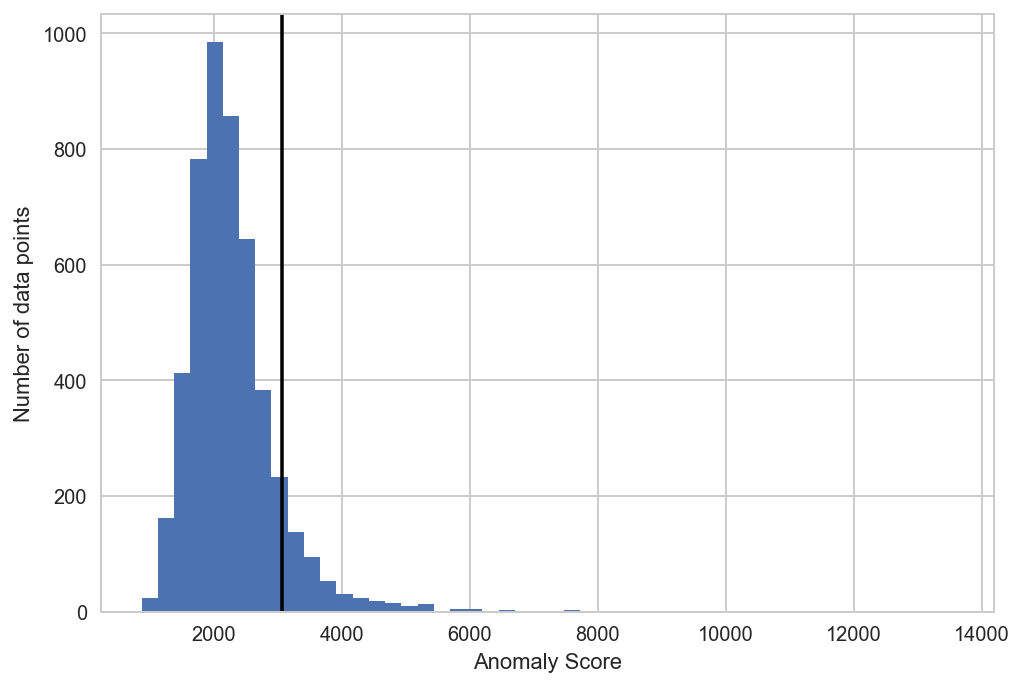

In [40]:
plt.hist(ab_score, bins=50)
plt.axvline(min_ab_score, c='k')
plt.xlabel('Anomaly Score')
plt.ylabel('Number of data points')
plt.show()

In [43]:
# outliers in dataset
wine.iloc[np.where(outlier==1)].head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
14,8.3,0.42,0.62,19.25,0.040,41.0,172.0,1.0002,2.98,0.67,9.7,5
17,6.2,0.66,0.48,1.20,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,8
20,6.2,0.66,0.48,1.20,0.029,29.0,75.0,0.9892,3.33,0.39,12.8,8
23,7.6,0.67,0.14,1.50,0.074,25.0,168.0,0.9937,3.05,0.51,9.3,5
40,6.7,0.23,0.39,2.50,0.172,63.0,158.0,0.9937,3.11,0.36,9.4,6


### 3.2. Clustering

#### DBSCAN 
In clustering topic, [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) can be used to detect outliers based on concept core points - edge points. If a point is neither a core point nor edge point, it will be considered as an outlier.

In [3]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [46]:
dbscan = DBSCAN(eps=9, min_samples=5)
cluster = dbscan.fit_predict(wine)
result = wine.assign(cluster=cluster)

In [48]:
result[result['cluster']==-1].head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,cluster
111,7.2,0.27,0.46,18.75,0.052,45.0,255.0,1.0000,3.04,0.52,8.9,5,-1
227,7.1,0.25,0.32,10.30,0.041,66.0,272.0,0.9969,3.17,0.52,9.1,6,-1
245,6.1,0.18,0.36,2.00,0.038,20.0,249.5,0.9923,3.37,0.79,11.3,6,-1
325,7.5,0.27,0.31,5.80,0.057,131.0,313.0,0.9946,3.18,0.59,10.5,5,-1
387,6.3,0.39,0.35,5.90,0.040,82.5,260.0,0.9941,3.12,0.66,10.1,5,-1


#### Clustering-based

- *Small and large cluster*:
Assume the clustering algorithm split dataset into $c$ cluster sorted by size in descending order $\mathcal{C}=\{C_1,C_2, \dots ,C_c\}$. Let $LC=\{C_1,\dots,C_b\}$ is a set of large cluster, $SC = C - LC$ is a set of small cluster. $|C_i|$ is the size of cluser $C_i$. To determine $b$ -  number of large cluster large, $b$ has sastisfy one of these conditions:

$$\begin{aligned}
\alpha &\leq \frac{\sum^b_{i=1} |C_i|}{N} \\
\beta  &\leq \frac{|C_b|}{|C_{b+1}|} \\
\end{aligned}$$

$\alpha$ usually is 0.9 - this coef considers that the most data points are not outliers, therefore the clusters has a large porpotion of data are the large clusters. $\beta$ is default set equal to 5 - this consider that there are significant different in size of large and small clusters.

- *CBLOF*: After defining small and large cluster, [CBLOF](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.cblof.CBLOF) calculates the anomaly score to classifie outlier. The CBLOF score of data point $p$ is defined as:

$$ \text{CBLOF}_p = 
\begin{cases}
|C_i| \cdot \min(d(p,C_j)) & \text{ if }  C_i \in \text{ SC and } C_j \in \text{ LC } \\
|C_i| \cdot d(p,C_i) & \text{ if } C_i \in \text{ LC }\\
\end{cases}$$

The formula simplify states that score is equal to the distance to the nearest large cluster multiplie by the size of the cluster the object belong to

In [3]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [83]:
cblof_ = cblof.CBLOF(n_clusters=10)
cblof_.fit(wine)

CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=10, n_jobs=None, random_state=None,
   use_weights=False)

In [84]:
cblof_.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [85]:
wine.iloc[np.where(cblof_.labels_==1)].shape

(490, 12)

### 3.3. One-class SVM

In classification, SVM is usually used in multi-class problems but in anomaly detection, there is just 1 class in all dataset, the algorithm must classify a new observation is in class or not. This is the idea of [One-class SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM). Note that in feature space the inner product of every point with the origin is $0$ - Hence there is low similarity between the points in the dataset and the origin. Therefore, OCSVM tries to find a hyperplane in feature space that maximizes the distances from the origin (outlier points) and minimizes the distance to the other datapoints (similar points)

This algorithm is consider as [novelty detection](https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-and-outlier-detection) (a kind of semi-supervised) which the training data do not contain outliers, the algorithm only detects the new observation is an outlier or not. Thus, it not suitable if there are outliers in the training set

In [3]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [88]:
svm = ocsvm.OCSVM(kernel='rbf')
svm.fit(wine)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [89]:
wine.iloc[np.where(svm.labels_==1)].shape

(490, 12)

### 3.4. KNN

For an observation, a distance from a datapoint to its $k_{th}$ nearest neighbor could be viewed as the outlying score. Three kNN detectors are supported: 
- Largest: use the last distance to the kth neighbor as the outlier score 
- Mean: use the average of all k neighbors as the outlier score 
- Median: use the median of the distance to k neighbors as the outlier score

In [10]:
wine = pd.read_csv(r'../../data/wine_quality.csv')
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [15]:
knn_ = knn.KNN(n_neighbors=10, method='mean')
knn_.fit(wine)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=10, p=2,
  radius=1.0)

In [16]:
wine.iloc[np.where(knn_.labels_==1)].shape

(490, 12)

## 4. Dedicated algorithms

### 4.1. Local Outlier Factor
[LOF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.lof) is widely uses in anomaly detection specially for local outlier. It computes the local density deviation of a given data point with respect to its neighbors. A point will be considered as outlier when it has a significantly lower density than it neighbors. In other word, LOF compares the local density of a point to local density of its k-nearest neighbors and gives a score as final output. The disadvantage of LOF or proximity-based algorithms is it costs time very much to calculate the distance between large data points.

The process of LOF follow these step:
- Determined the distance from data point $p_i$ to $k_{th}$ nearest neighbors (pyod support all distance metrics from sklearn and scipy). Get the max distance among $k$ points - this is called *K_distance*. The number of neighbors of $p_i$ can greater or equal $k$ due to the distance between them - denote $|N_p|$ 
- Computes the *reachability density (RD)* of each $p_i$ related to others. RD is defined as the maximum of K-distance of $p_i$ and the distance between $p_i$ and $p_j$:

$$\text{RD}(p_i,p_j) = \max(\text{K_distance}_{p_i}, d(p_i,p_j))$$

:::{image} ../image/local_outlier_factor.png
:height: 250px
:align: center
:::
<br>

- Computes the *local reachability density (LRD)*. LRD is inverse of the average RD of $p_i$ from its neighbors. The larger average RD leads to the smaller LRD - it means the density of $p_i$ is quite low:

$$\text{LRD}_{p_i}= \frac{1}{\sum_{p_j \in N_p}\frac{\text{RD}(p_i,p_j)}{|N_p|} } $$

- Calculates the *LOF score* for each $p_i$ - LOF score is the ratio of the average LRD of the $K$ neighbors of $p_i$ to the LRD of $p_i$. If a point is inliner, the LRD of this point is approximately equal to its neighbors that leads to LOF is nearly equal to 1. On the other hand, if the point is an outlier, the LRD of a point is less than the average LRD of neighbors, then LOF value will be high:

$$\text{LOF}_{p_i} = \frac{\sum_{p_j \in N_p} \text{LRD}_{p_j}}{|N_p|} \cdot \frac{1}{\text{LRD}_{p_i}}$$

### 4.2. Histogram-based

The idea of HBOS (Histogram-based Outlier Score) is based on assumption that the variables are independence of each other. HBOS is constructing a histogram for each variable, then calculating the *univariate outlier score* for each observation and finally sum up to measure the outlier score of an observation. HBOS is suitable for global and clustered outliers, it also has very fast computing time - especially for large dataset.

Firstly, the algorithm will create histogram of each variable $d$. If a feature is numerical, bin it to get its histogram, if it is categorical, just count the values of each category. The height of bins ($h_d$) which data point belongs is the measure of outlier-ness. To get higher value for outlier, we inverse $h_d$ and standardize score by log transform to ensures all the univariate scores can be summed up with equal weight. The formula of outlier score of a point $p$ is very simply:

$$\text{HBOS}_p = \sum_{d=0}^D \log(\frac{1}{h_d})$$

The outliers will have a higher score than inliers points and these will be labelled 1 due to the outlier threshold we set. The challenge of HBOS is, it can be sensitive to the bin width of the histogram. If the bins are too narrow, the normal data points falling in these bins will be identified as outliers and vice versa. To produce a model with a stable outcome, the strategy is to build HBOS models with a range of histogram widths to obtain multiple scores and then aggregate the scores (by average or max average). This approach will reduce  overfitting and increase prediction accuracy. 

### 4.3. Isolation Forest
[Isolation Forest](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.iforest.IForest) detects the outliers based on ensembling binary decision trees to isolate outliers from the others. Relying on the characteristics of outliers are few and difference, IForest built each tree using sub-sample of dataset, then randomly seleted a feature and a random threshold to split the tree. The process of splitting continue until all instance has been isolated or the tree reach the maximum height or all same-value data points go into same node. The outliers will have short path to the root than others, especially when all tree in the forest say that. Formula of anomaly score depends on the average of path length to the root $\overline{h_p}$, number of instances in node - $n$ and unsuccesfull path in binary search tree $c(n)$:

$$\begin{aligned}
\text{iForest}_p &= 2^{-\frac{\overline{h}_p}{c(n)}} \\
c(n) &= 2 \cdot (\log(n-1)+0.577) - \frac{2(n-1)}{n} \\
\end{aligned}$$

Iforest just requires 2 params which are number of trees and sub-sample size - it works very well with small sample sizes and high-dimensional data, time consuming of this method is also fast and it can apply for all 4 types of anomaly. But iForest also has a disadvantage that a node in an iTree is split based on a threshold value, the data is split into left and right branches resulting in horizontal and vertical branch cuts - this will lead to some outliers are passed.

### 4.4. Connectivity-based
[COF](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cof) (Connectivity-based Outlier Factor) is another version of LOF. In LOF, the theory is that data points are distributed in circle around the instance, but in the case there is a linear relationship between data points, the distance metric in LOF is no longer correct. COF calculates the anomaly score based on average *chain distance* between points and their neighbors. Therefore, COF is suitable for local and dependency outliers but like LOF, the time cosuming of COF is quite high with large dataset.

As same as LOF, COF firstly find $k$ nearest neighbors of point $p$ then arrange them in order of closest distance to $p$. Call $e_k$ is the *edge distance*, equals to each pair of points distance, example $e_2$ is the distance between $P_2$ and $P_3$, we calculates average chain distance for each instance:

$$\text{ACD}_p = \sum_{i=1}^k \frac{2(k+1-i)}{k(k+1)} e_i$$

:::{image} ../image/connectivity_based_outlier_factor.png
:height: 180px
:align: center
:::
<br>

At last, anomaly score is generated by ratio of average chaining distance of instance and the average of average chaining distance of $k$ nearest neighbor of this point. The higher the score, the easier it is to be an outlier.

$$\text{COF}_p = \frac{\text{ACD}_p}{\frac{\sum ACD_k}{k}}$$

### 4.5. COPula-based
[COPOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.copod.COPOD) (COPula-based Outlier Detection) is a parameter-free algorithm, which is built based on empirical multivariate distribution. Beside of no hyperparameters, it is also fast and computationally efficient, suitable for high-himensional data. The math behind this algorithm is quite complicated, simply understand that COPOD constructs the multivariate cumulative distribution function, and then uses it to predict tail probabilities of each given data point to determine its level of extremeness. The score in this case is not outlier probability but measuring the likelihood of a row, relative to other points in the dataset.

### [w] Autoencoder

### 4.7. Implementation 

All unsupervised algorithms in Pyod have an importance hyperameter is `contamination` which is ratio of anomaly in the dataset. Some notable hyperparams in each algorithm:

Algorithm| Hyperparam| Default
:--------|:---------|:-------
LOF|`n_neighbors`|20
LOF|`metric`|minkowski
HBOS|`n_bins`|10
HBOS|`alpha`|0.1
IForest|`n_estimators`|100
IForest|`max_samples`|auto
IForest|`max_features`|1
COF|`n_neighbors`|20
COF|`method`|fast

In [18]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import ParameterGrid
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.hbos import HBOS
from pyod.models.cof import COF
from pyod.models.copod import COPOD

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [3]:
dfWine = pd.read_csv(r'../data/wine_quality.csv')
dfWine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


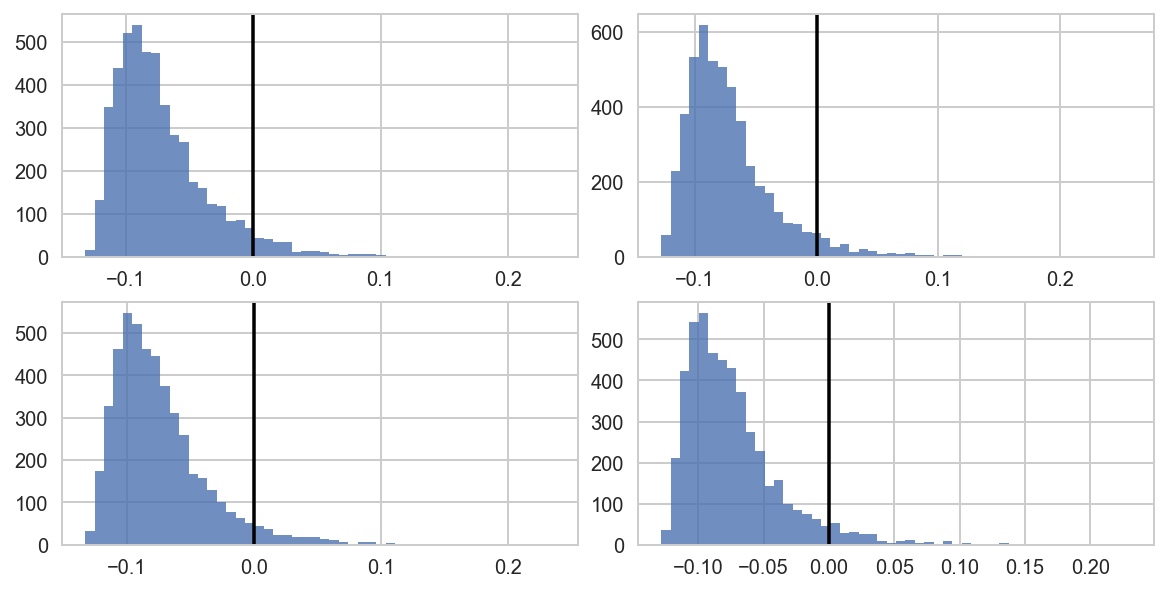

In [20]:
paramsGrid = ParameterGrid({
    'n_estimators': [50, 100],
    'max_samples': [0.5, 0.5],
})

fig, ax = plt.subplots(figsize=(8, 4), nrows=2, ncols=2, constrained_layout=True)
for i, params in enumerate(paramsGrid):
    model = IForest(contamination=0.05, **params)
    model.fit(dfWine)
    score = model.decision_function(dfWine)
    thres = model.threshold_
    ax.flatten()[i].hist(score, bins=50, alpha=0.8)
    ax.flatten()[i].axvline(thres, c='k')
plt.show()

## Resources
- https://github.com/openvinotoolkit/anomalib
- https://github.com/SeldonIO/alibi-detect
- https://github.com/vc1492a/PyNomaly
- https://madm.dfki.de/_media/theses/bachelorthesis-amer_2011.pdf
- https://www.goldiges.de/publications/Anomaly_Detection_Algorithms_for_RapidMiner.pdf
- https://stats.stackexchange.com/questions/313857/why-one-class-svm-seperate-from-the-origin
- https://towardsdatascience.com/local-outlier-factor-lof-algorithm-for-outlier-identification-8efb887d9843
- https://medium.com/dataman-in-ai/anomaly-detection-with-histogram-based-outlier-detection-hbo-bc10ef52f23f
- https://www.goldiges.de/publications/HBOS-KI-2012.pdf
- https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest
- https://arxiv.org/pdf/2009.09463.pdf
- https://towardsdatascience.com/fast-accurate-anomaly-detection-based-on-copulas-copod-3133ce9041fa